In [1]:
import sys
sys.path.append('/home/achint/Generative_Modelling/POISEVAE-master')
import os, copy, time
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal, Laplace
from tqdm import tqdm
import matplotlib.pyplot as plt
import poisevae
from poisevae.utils import CategoricalImage as Categorical
from poisevae.datasets import MNIST_MNIST
from poisevae.networks.MNISTMNISTNetworks_X import EncMNIST1, DecMNIST1, EncMNIST2, DecMNIST2
from poisevae.networks.MNISTMNISTNetworks_pixelcnn import pixelcnn_decoder
# from poisevae.networks.conv_layers import MaskedConv2d, CroppedConv2d
from poisevae.networks.model import PixelCNN

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
MNIST_PATH = "/home/achint/datasets/MNIST/%s.pt"
SVHN_PATH = "/home/achint/datasets/SVHN/%s_32x32.mat"

joint_dataset_train = MNIST_MNIST.MNIST_MNIST(mnist_pt_path_1=MNIST_PATH % 'training', mnist_pt_path_2=MNIST_PATH % 'training')
joint_dataset_test  = MNIST_MNIST.MNIST_MNIST(mnist_pt_path_1=MNIST_PATH % 'test', mnist_pt_path_2=MNIST_PATH % 'test')

In [3]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(joint_dataset_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(joint_dataset_test, batch_size=batch_size, shuffle=True, drop_last=True)
len(train_loader), len(test_loader)

(937, 156)

In [4]:
# def loss_function(x_rec, x):
#     x_rec = x_rec.flatten(-3,-1)#.flatten(0, 1)
#     color_level = 256
#     x = (x * (color_level - 1)).floor()#.long()
#     x_ = torch.zeros_like(x_rec)#.long()
#     for i in range(x_rec.shape[0]):
#         x_[i, :] = x[i].unsqueeze(0)
    
#     print(x_rec.shape, x_.shape)
#     x_rec = x_rec.flatten(0, 1)
#     x_ = x_.flatten(0, 1)
    
#     ce_loss = nn.CrossEntropyLoss(reduction='none')
#     print(x_rec.shape, x_.shape)
#     MSE = ce_loss(x_rec,x_).sum(dim=-1)
#     print(MSE.shape)
#     return MSE

In [5]:
lat1, lat2 = 20, 20
enc_mnist1 = EncMNIST1(lat1, lat2).to(device)
enc_mnist2 = EncMNIST2(lat1, lat2).to(device)

dec_mnist1 = pixelcnn_decoder(PixelCNN(lat1, 1)).to(device)
dec_mnist2 = pixelcnn_decoder(PixelCNN(lat1, 1)).to(device)

# Options: 'autograd' and 'gradient'
vae = poisevae.POISEVAE_Gibbs('gradient',
                              [enc_mnist1, enc_mnist2], [dec_mnist1, dec_mnist2], likelihoods=[Categorical, Categorical],
                              latent_dims=[lat1, (lat2)], enc_config='nu', KL_calc='derivative', 
                              batch_size=batch_size, reduction='mean'
                             ).to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)
writer = None


In [6]:
PATH = '/home/achint/runs'
epoch = 0
epochs = 1 + epoch
fname = 'out%s.txt' % time.strftime('%m%d%H%M%S')
G = [vae.get_G().detach().cpu().numpy()]
detach_G = True

for epoch in tqdm(range(epoch, epochs)):
    with poisevae._debug.Capturing(fname, disable_print=False) as output:
        poisevae.utils.train(vae, train_loader, optimizer, epoch, 3, 2, writer, img=torch.zeros(batch_size * 2, 784), generate_mode=False,detach_G=detach_G)
    G.append(vae.get_G().detach().cpu().numpy())

#     poisevae.utils.test(vae, test_loader, epoch, 3, 2, writer, img=torch.zeros(batch_size * 2, 784), generate_mode=False)
    if (epoch+1) % 10 == 0 and epoch > 0:
        poisevae.utils.save_checkpoint(vae, optimizer, os.path.join(PATH, 'training_%d.pt' % (epoch+1)), epoch+1)


100%|████████████████████████████████████████████| 1/1 [04:07<00:00, 247.70s/it]


In [19]:
poisevae.utils.save_checkpoint(vae, optimizer, os.path.join(PATH, 'training_%d.pt' % (epoch+1)), epoch+1)

In [20]:
with torch.no_grad():
    for i, data in enumerate(test_loader):
        results = vae([data[0].to(device, dtype=torch.float32), data[1].to(device, dtype=torch.float32)],img=torch.zeros(batch_size * 2, 784), generate_mode=False, n_gibbs_iter=2)
        break

mu max: 6.5694780349731445 mu mean: 1.0166559219360352
mup max: 2.9979584217071533 mup mean: 0.286971777677536
var min: 8.819286967387541e-11 var mean: 0.005669192876666784
varp min: 5.995740139042027e-05 varp mean: 0.07633446156978607
torch.Size([64, 1, 784]) torch.Size([64, 2, 784, 256])
torch.Size([64, 1, 784]) torch.Size([64, 2, 784, 256])
total loss: 1872.201171875 kl term: 0.0
rec1 loss: 935.3790893554688 rec2 loss: 936.8221435546875



In [21]:
x_rec = results['x_rec']
if isinstance(x_rec[0], torch.distributions.Distribution):
    x_rec = [x_rec[0].probs, x_rec[1].probs]
    # idx = torch.where(results['weights'] == results['weights'].max(dim=1).values[:, None])
    # x_rec = [x_rec[0].loc[idx], x_rec[1].loc[idx]] # (batch, IW samples, ...)

In [22]:
x_rec = [x_rec[0].max(dim=-1).indices.squeeze()[:, -1],x_rec[1].max(dim=-1).indices.squeeze()[:, -1]]
x_rec[0].shape

torch.Size([64, 784])

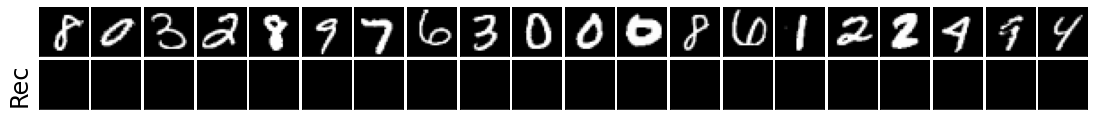

In [23]:
ncols = min(len(x_rec[0]), 20)
fig, ax = plt.subplots(nrows=2, ncols=ncols, figsize=(15, 1.5))
for i, aux in enumerate(zip(data[0], x_rec[0])):
    if i >= ncols:
        break
    for j, im in enumerate(aux):
        ax[j, i].imshow(im.cpu().numpy().reshape(28, 28), cmap='gray')
        ax[j, i].set_xticks([])
        ax[j, i].set_yticks([])
ax[1, 0].set_ylabel('Rec', fontsize=24)
fig.tight_layout(pad=0)
# fig.savefig(PATH + 'MNISTRec.pdf', dpi=300)

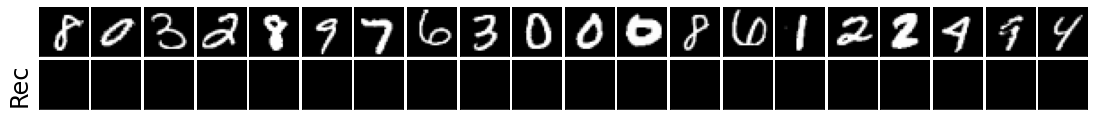

In [24]:
ncols = min(len(x_rec[1]), 20)
fig, ax = plt.subplots(nrows=2, ncols=ncols, figsize=(15, 1.5))
for i, aux in enumerate(zip(data[1], x_rec[1])):
    if i >= ncols:
        break
    for j, im in enumerate(aux):
        ax[j, i].imshow(im.cpu().numpy().reshape(28, 28), cmap='gray')
        ax[j, i].set_xticks([])
        ax[j, i].set_yticks([])
ax[1, 0].set_ylabel('Rec', fontsize=24)
fig.tight_layout(pad=0)

In [25]:
x_rec = results['x_rec']
if isinstance(x_rec[0], torch.distributions.Distribution):
    x_rec = [x_rec[0].probs, x_rec[1].probs]

In [41]:
x_rec

[CategoricalImage(probs: torch.Size([64, 2, 784, 256]), logits: torch.Size([64, 2, 784, 256])),
 CategoricalImage(probs: torch.Size([64, 2, 784, 256]), logits: torch.Size([64, 2, 784, 256]))]

In [42]:
x_rec = results['x_rec']
torch.sum(x_rec[0].probs,dim=-1)

tensor([[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

        [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

        [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

        ...,

        [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

        [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

        [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]]],
       device='cuda:0', dtype=torch.float64)

In [15]:
x_rec[0].max()

tensor(0.9997, device='cuda:0', dtype=torch.float64)

In [16]:
x_rec1 = x_rec[0].max(dim = -1).indices.squeeze()#[:, -1]

In [17]:
data[0].min()

tensor(0.)

mu max: 6.239203453063965 mu mean: 1.0079312324523926
mup max: 2.8652608394622803 mup mean: 0.2709880471229553
var min: 2.54407217514796e-10 var mean: 0.005256666336208582
varp min: 0.0001618920941837132 varp mean: 0.07396327704191208


RuntimeError: The size of tensor a (128) must match the size of tensor b (960) at non-singleton dimension 0

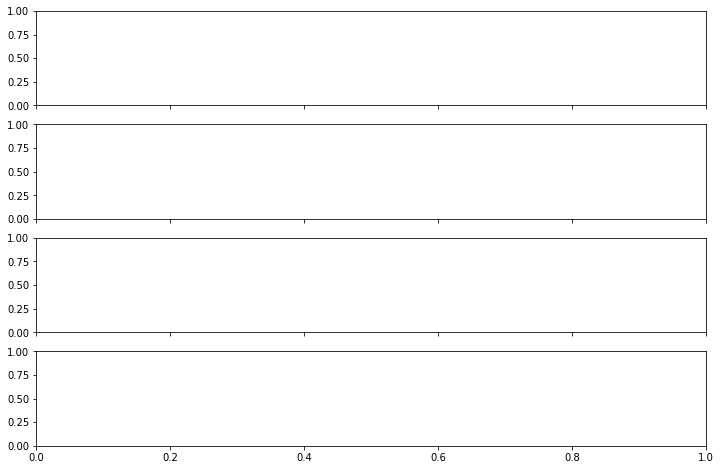

In [18]:
epochs = ([1])
fig, ax = plt.subplots(ncols=len(epochs), nrows=4, figsize=(12, 8), sharex='col')

for j, t in enumerate(epochs):
    vae, _, _ = poisevae.utils.load_checkpoint(vae, load_path=os.path.join(PATH, 'training_%d.pt'%t))
    with torch.no_grad():
        for _, data in enumerate(test_loader):
            results = vae([data[0].to(device, dtype=torch.float32), data[1].to(device, dtype=torch.float32)],img=torch.zeros(batch_size * 2, 784), generate_mode=False)
            break
    mu, var = results['param1'], results['param2']
    for i in (0, 1):
        ax[j, i].plot(mu[i].detach().cpu().numpy().T)
        ax[j, i].set_title('mu%d' % (i+1))
        ax[j, 2+i].plot(var[i].detach().cpu().numpy().T)
        ax[j, 2+i].set_title('var%d' % (i+1))
    ax[j, 0].set_ylabel('epoch = %d' % t)
fig.tight_layout(pad=0)